In [15]:
import s3fs
import xarray as xr
import urllib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy as cy
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress
import datetime as dt
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as ticker
import warnings
from shapely.errors import ShapelyDeprecationWarning
from matplotlib.colors import BoundaryNorm

In [16]:
def transform_lat_lon_to_xy(lat, lon):
    # Example - your x and y coordinates are in a Lambert Conformal projection
    data_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
    # Transform the point - src_crs is always Plate Carree for lat/lon grid
    x, y = data_crs.transform_point(lon, lat, src_crs=ccrs.PlateCarree()) 
    x = x /(10**3)
    y = y /(10**3)
    return x, y

In [17]:
def find_var_on_Lambert_Azimuthal_Grid(ds, var='ice_conc', lat = 80.0, lon = 100.0):
    # Find indices where lon and lat are closest to point-of-interest.
    idxs = (np.abs(ds.lon - lon) + np.abs(ds.lat - lat)).argmin(dim = ["xc", "yc"])

    # Retrieve value of variable at indices
    value = ds[var].isel(idxs).values

    # Check the actual lat and lon
    lat_in_ds = ds.lat.isel(idxs).values
    lon_in_ds = ds.lon.isel(idxs).values

    # Print some results.
    print(f"Thickness at ({lat_in_ds:.3f}, {lon_in_ds:.3f}) = {value[0]} {ds[var].units}.")
    return value[0]

In [18]:
# Function
def ice_trend_data(xr_ice, xc_min, xc_max, yc_min, yc_max, months):
    xr_ice_coords_limited = xr_ice.sel(xc=slice(xc_min, xc_max)).sel(yc=slice(yc_min, yc_max))
    months_bool = xr_ice['time'].dt.month.isin(months)
    xr_ice_month_coords_limited = xr_ice.isel(time=months_bool)
    
    ice_years = np.unique(xr_ice.time.dt.year)
    ice_years_limited = []
    for i, y in enumerate(ice_years):
        try:
            ice_year_limited =  xr_ice_month_coords_limited.sel(time=str(y)).mean(dim='time').variables['ice_conc'][:,:]
            ice_years_limited.append(ice_year_limited)
        except:
            ice_years = np.delete(ice_years, i)

        
    
    ice_years_array_limited = np.array(ice_years_limited)
   
    df_limited = pd.DataFrame(ice_years_array_limited.reshape(len(ice_years_array_limited), -1), index=ice_years.tolist())
    
    
    final_df_limited = df_limited.apply(pd.Series)
    final_df_limited[np.isnan(final_df_limited)] = 0
    
    x_order_limited = np.arange(1, len(ice_years)+1, 1)
    slopes_limited = []
    for i in np.arange(25600):
        slope_limited = scipy.stats.mstats.theilslopes(y=final_df_limited.iloc[:,i], x=x_order_limited)[0]
        slopes_limited.append(slope_limited)
        np_slopes_limited = np.array(slopes_limited)
    
    np_slopes_2d_limited = np_slopes_limited.reshape(160, 160)
    
    return np_slopes_2d_limited

In [19]:
def ice_trend_plot(slopes_2d, title, cb_label, xc_min, xc_max, yc_min, yc_max, xr_ice): 
    xr_ice_coords_limited = xr_ice.sel(yc=slice(yc_max, yc_min)).sel(xc=slice(xc_min, xc_max))
    
    
    print(xr_ice_coords_limited)
    
    proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0) #what projection is the data in
    fig = plt.figure(figsize=(15,5)) #size
    ax = plt.axes(projection=proj)     
    # ease_extent =  [xc_min, xc_max, yc_min, yc_max] #lon and lat max min   
    # ax.set_extent(ease_extent, crs=proj) 

    ax.gridlines(linestyle='--',color='black')    
    data = slopes_2d
    gridlons, gridlats = np.meshgrid(np.array(xr_ice_coords_limited['xc']),np.array(xr_ice_coords_limited['yc'])) 
    
    gridlons, gridlats = np.meshgrid(np.linspace(1, 160, 160), np.linspace(1,60,160))
    
    mapped_grid = ax.pcolormesh(gridlons, gridlats, data, transform=proj, 
                                cmap='bwr')    
    
    # plt.title(str(var)+' time: '+str(time_index), size=14)
    ax.coastlines(resolution="50m", linewidth=1)
    #customise your colourbar
    # cb = plt.colorbar(mapped_grid, orientation="vertical", pad=0.02, extend='both',
    #                  aspect=16, shrink=0.8, format=ticker.FuncFormatter(fmt))
    # cb.set_label('Trend in sea ice concentration in summer [%]', rotation=270, labelpad=15, size=16)
    # cb.ax.tick_params(labelsize=15)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [20]:
def find_var_on_Lambert_Azimuthal_Grid(ds, var='ice_conc', lat = 80.0, lon = 100.0):
    # Find indices where lon and lat are closest to point-of-interest.
    idxs = (np.abs(ds.lon - lon) + np.abs(ds.lat - lat)).argmin(dim = ["xc", "yc"])

    # Retrieve value of variable at indices
    value = ds[var].isel(idxs).values

    # Check the actual lat and lon
    lat_in_ds = ds.lat.isel(idxs).values
    lon_in_ds = ds.lon.isel(idxs).values

    # Print some results.
    print(f"Thickness at ({lat_in_ds:.3f}, {lon_in_ds:.3f}) = {value[0]} {ds[var].units}.")
    return value[0]


In [21]:
def transform_lat_lon_to_xy(lat, lon):
    # Example - your x and y coordinates are in a Lambert Conformal projection
    data_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
    # Transform the point - src_crs is always Plate Carree for lat/lon grid
    x, y = data_crs.transform_point(lon, lat, src_crs=ccrs.PlateCarree()) 
    x = x /(10**3)
    y = y /(10**3)
    return x, y

In [22]:
def slice_with_lat_lon(lon_min, lon_max, lat_min, lat_max, ds):
    data_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
    # Transform the point - src_crs is always Plate Carree for lat/lon grid
    x_min, y_min = data_crs.transform_point(lon_min, lat_min, src_crs=ccrs.PlateCarree()) 
    x_max, y_max = data_crs.transform_point(lon_max, lat_max, src_crs=ccrs.PlateCarree()) 
    print(x_min, y_min, x_max, y_max)
    x_min_km, y_min_km, x_max_km, y_max_km = x_min/10**3, y_min/10**3, x_max/10**3, y_max/10**3
    print(x_min_km, y_min_km, x_max_km, y_max_km)
    
    ds_sliced = ds['ice_conc'].sel(xc=slice(x_min_km, x_max_km)).sel(yc=slice(y_min_km, y_max_km))
    return ds_sliced

In [425]:
# grid = EASE2GRID(name='EASE2_N25km', epsg=6931, x_min=-17367530.45, y_max=7314540.83, res=36032.22, n_cols=432, n_rows=432)

# # or using parameters taken from NSIDC and kept in SUPPORTED_GRIDS
# grid = EASE2GRID(name='EASE2_G36km', **SUPPORTED_GRIDS['EASE2_G36km'])

# # convert longitude and latitude to row and col indices
# point_lon = 17.4
# point_lat = 49.4

# # row should be 48, col should be 528
# col, row = grid.lonlat2rc(lon=point_lon, lat=point_lat)

# # get lon, lat of the center of the pixel
# pixel_center_lon, pixel_center_lat = grid.rc2lonlat(col=col, row=row)

In [481]:
def ice_slope_2d(months, years):
    years = np.arange(years[0], years[-1]+1)
    array_years = []
    for y in years:
        ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_{y}.nc')
        months_bool = ds['time'].dt.month.isin(months)
        ds_months_limited = ds.isel(time=months_bool).mean(dim='time')
        # print(ds_months_limited)
        data_array = np.array(ds_months_limited['ice_conc'].where(ds_months_limited.lat>60, drop=True))
        # print(data_array)
        # plt.pcolormesh(data_array)
        # plt.show()
        array_years.append(data_array)   
    array_years_np = np.array(array_years)
    df = pd.DataFrame(array_years_np.reshape(len(array_years_np), -1), index=years.tolist())
    x_order = np.arange(1, len(years)+1, 1)
    slopes = []
    for i in np.arange(264*264):
        slope = scipy.stats.mstats.theilslopes(y=df.iloc[:,i], x=x_order)[0]
        slopes.append(slope)
    np_slopes = np.array(slopes)
    np_slopes_2d = np_slopes.reshape(264, 264)
    return np_slopes_2d

In [125]:
def ice_trend(months, years, title, figname):
    fig = plt.figure(1, figsize=[15,10])
    ax = plt.subplot(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90.0))
    #ax = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ds = xr.open_dataset('data/sea_ice_conc/ice_conc_2000.nc')
    sea_ice_above_60 = ds['ice_conc'][0,:,:].where(ds.lat>60, drop=True)

    gridlons = sea_ice_above_60['lon'].values
    gridlats = sea_ice_above_60['lat'].values 
    sea_ice_array = ice_slope_2d(months, years)
    ax.gridlines(linestyle='--',color='black')  
    cmap = plt.get_cmap('RdBu', 9)
    
    mapped_grid = ax.pcolormesh(gridlons, gridlats, sea_ice_array, transform=ccrs.PlateCarree(), shading='nearest',
                                cmap=cmap, vmin=-3, vmax=3)

    #ax.set_extent([-45, 45, 60, 90], crs=ccrs.PlateCarree())

    ax.coastlines()
    #XR_all_years['ice_conc'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.epsg(6931))

    cb = plt.colorbar(mapped_grid, orientation="vertical", pad=0.02, 
                      aspect=16, shrink=0.8)
    cb.set_label('Trend in sea ice concentration [% yr$^{-1}$]',size=12,rotation=270,labelpad=15)
    cb.ax.tick_params(labelsize=15)
    ax.set_title(title, size=15)
    plt.show()
    fig.savefig(f'fig/{figname}.png')

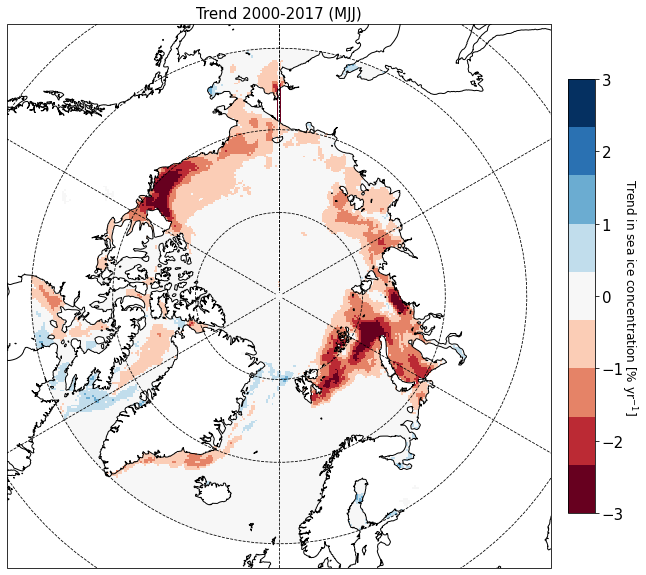

In [522]:
# Summer 2000-2017
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    ice_trend(months=[5,6,7], years=[2000,2017], title='Trend 2000-2017 (MJJ)', figname='ice_2000_2017_mjj')

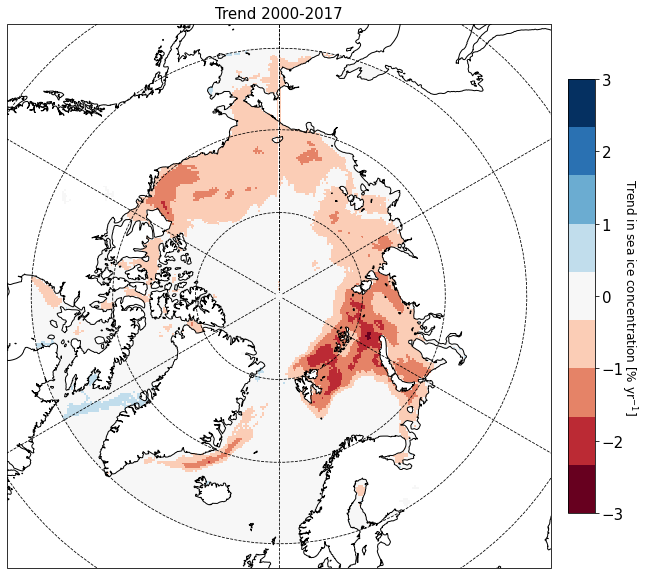

In [521]:
# All seasons 2000-2017
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    ice_trend(months=[1,2,3,4,5,6,7,8,9,10,11,12], years=[2000,2017], title='Trend 2000-2017', figname='ice_2000_2017_all')

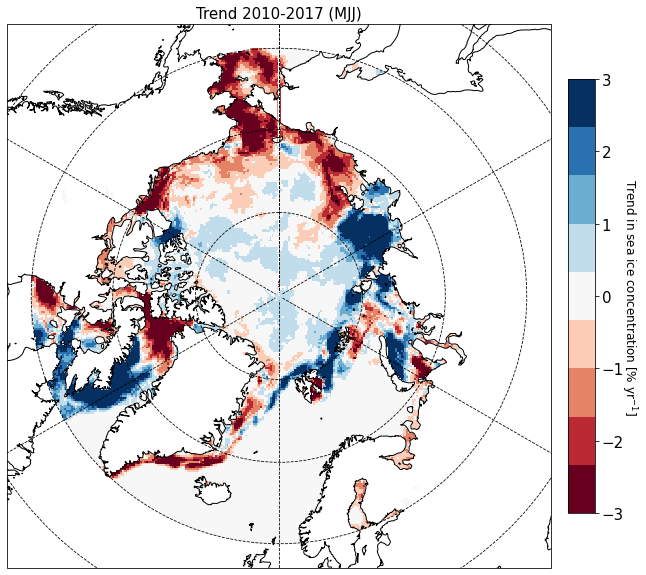

In [520]:
# Summer 2010-2017
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    ice_trend(months=[5,6,7], years=[2010,2017], title='Trend 2010-2017 (MJJ)', figname='ice_2010_2017_mjj')

In [435]:
# def fmt(x, pos):
#     a, b = '{:.2e}'.format(x).split('e')
#     b = int(b)
#     return r'${} \times 10^{{{}}}$'.format(a, b)

### Theo's way

In [167]:
np_array = ds.mean(dim='time').ice_conc.values
a = ((ds.lat>60)&(ds.lon>-180))
np_array[~a] = np.nan
np_array.shape

(432, 432)

/Users/kei/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/Users/kei/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/kei/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi

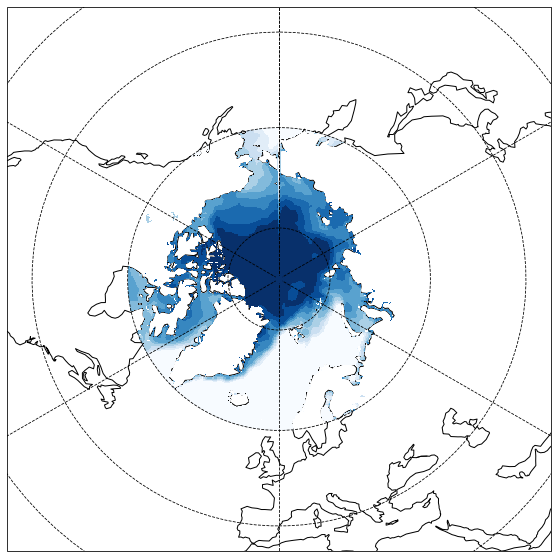

In [168]:
fig = plt.figure(1, figsize=[15,10])
ax = plt.subplot(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90.0))
cmap = plt.get_cmap('Blues', 10)
sea_ice_above_60 = ds['ice_conc'][0,:,:].where(ds.lat>60, drop=True)
gridlons = ds['lon'].values
gridlats = ds['lat'].values 
ax.gridlines(linestyle='--',color='black')  
ax.coastlines()
mapped_grid_summer = ax.pcolormesh(gridlons, gridlats, np_array, transform=ccrs.PlateCarree(), shading='auto',
                                cmap=cmap, vmin=0, vmax=100)

In [ ]:
def ice_theo(year):
    # np_array = ds.mean(dim='time').ice_conc.values
    # a = ((ds.lat>60)&(ds.lon>-180))
    # np_array[~a] = np.nan
    # np_array.shape

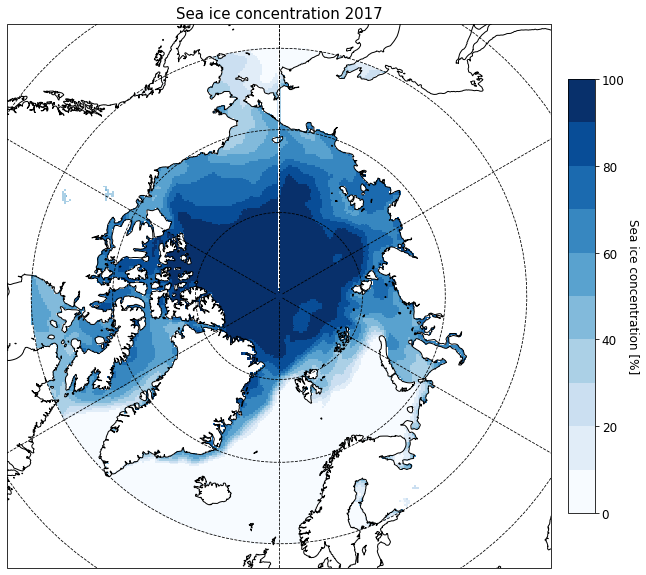

In [519]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    ice_one_year(months=[1,2,3,4,5,6,7,8,9,10,11,12], year=2017, title='Sea ice concentration 2017', figname='ice_2017_mjj')

### One year 2017 

In [139]:
def ice_one_year(months, year, title, figname):
    fig = plt.figure(1, figsize=[15,10])
    ax = plt.subplot(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90.0))

    ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_{year}.nc')
    months_bool = ds['time'].dt.month.isin(months)
    ds_months_limited = ds.sel(time=months_bool).mean(dim='time')
    # ds_months_limited_array = np.array(ds_months_limited['ice_conc'][:,:].where(ds_months_limited.lat>60, drop=True))
    #        ds_months_limited = ds.isel(time=months_bool).mean(dim='time')
    data_array = np.array(ds_months_limited['ice_conc'].where(ds_months_limited.lat>60, drop=True))
    sea_ice_above_60 = ds['ice_conc'][0,:,:].where(ds.lat>60, drop=True)

    gridlons = sea_ice_above_60['lon'].values
    gridlats = sea_ice_above_60['lat'].values 

    cmap = plt.get_cmap('Blues', 10)
    ax.gridlines(linestyle='--',color='black')  
    mapped_grid_summer = ax.pcolormesh(gridlons, gridlats,≈, transform=ccrs.PlateCarree(), shading='auto',
                                cmap=cmap, vmin=0, vmax=100)

    #ax.set_extent([-45, 45, 60, 90], crs=ccrs.PlateCarree())

    ax.coastlines()
    #XR_all_years['ice_conc'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.epsg(6931))

    cb = plt.colorbar(mapped_grid_summer, orientation="vertical", pad=0.02, 
                      aspect=16, shrink=0.8)
    cb.set_label('Sea ice concentration [%]',size=12,rotation=270,labelpad=15)
    cb.ax.tick_params(labelsize=12)

    ax.set_title(title, size=15)
    plt.show()
    fig.savefig(f'fig/{figname}.png')

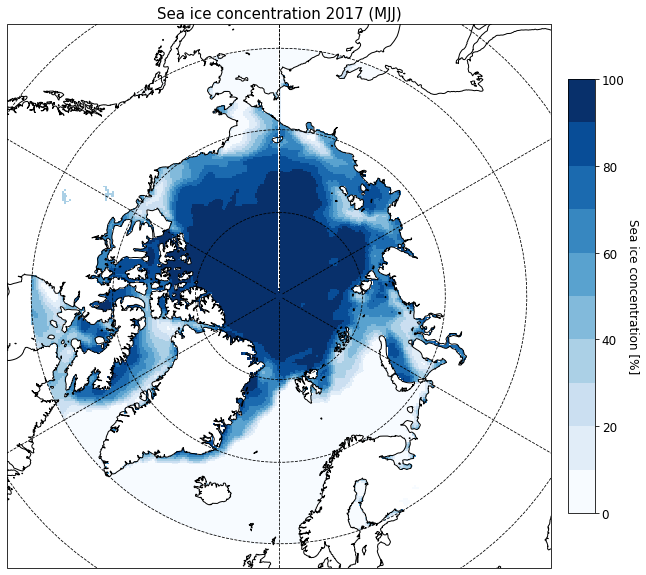

In [518]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    ice_one_year(months=[5,6,7], year=2017, title='Sea ice concentration 2017 (MJJ)', figname='ice_2017_mjj')

### Select for 'affected' and 'unaffected' areas

In [171]:
months = [5,6,7]
ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_2017.nc')
months_bool = ds['time'].dt.month.isin(months)
ds_months_limited = ds.sel(time=months_bool).mean(dim='time')
# ds_months_limited_array = np.array(ds_months_limited['ice_conc'][:,:].where(ds_months_limited.lat>60, drop=True))
#        ds_months_limited = ds.isel(time=months_bool).mean(dim='time')
data_array = np.array(ds_months_limited['ice_conc'].where(ds_months_limited.lat>60, drop=True))


In [385]:
ds_months_limited

<xarray.Dataset>
Dimensions:   (xc: 432, yc: 432)
Coordinates:
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat       (yc, xc) float32 16.62 16.82 17.02 17.22 ... 17.02 16.82 16.62
    lon       (yc, xc) float32 ...
Data variables:
    ice_conc  (yc, xc) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [479]:
years = np.arange(2000, 2018)
array_years = []
for y in years:
    ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_{y}.nc')
    months_bool = ds['time'].dt.month.isin(months)
    ds_months_limited = ds.isel(time=months_bool).mean(dim='time')
    # print(ds_months_limited)
    data_array = np.array(ds_months_limited['ice_conc'])
    # print(data_array)
    # plt.pcolormesh(data_array)
    # plt.show()
    array_years.append(data_array)   
array_years_np = np.array(array_years)
df = pd.DataFrame(array_years_np.reshape(len(array_years_np), -1), index=years.tolist())
x_order = np.arange(1, len(years)+1, 1)
slopes = []
for i in np.arange(432*432):
    slope = scipy.stats.mstats.theilslopes(y=df.iloc[:,i], x=x_order)[0]
    slopes.append(slope)
    if i % 5000 == 0:
        print(i)
np_slopes = np.array(slopes)
np_slopes_2d = np_slopes.reshape(432, 432)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000


In [490]:
ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_2017.nc')
ds.mean(dim='time')

<xarray.Dataset>
Dimensions:   (xc: 432, yc: 432)
Coordinates:
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat       (yc, xc) float32 ...
    lon       (yc, xc) float32 ...
Data variables:
    ice_conc  (yc, xc) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [503]:
ds2 = ds.drop_dims('time')

In [497]:
ds2['trend'] = (('yc','xc'), np_slopes_2d)

In [504]:
ds2

<xarray.Dataset>
Dimensions:  (xc: 432, yc: 432)
Coordinates:
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat      (yc, xc) float32 ...
    lon      (yc, xc) float32 ...
Data variables:
    *empty*
Attributes: (12/41)
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.62393
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    ...                        ...
    references:                Product User Manual v2p0 (April 2019),Algorith...
    contributor_name:          Thomas Lavergne, Signe Aaboe, Gorm Dybkjaer, S...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v65, 09 April 2019)
    product_status:            operational

In [502]:
def ice_slope_2d_432(months, years):
    years = np.arange(years[0], years[-1]+1)
    array_years = []
    for y in years:
        ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_{y}.nc')
        months_bool = ds['time'].dt.month.isin(months)
        ds_months_limited = ds.isel(time=months_bool).mean(dim='time')
        # print(ds_months_limited)
        data_array = np.array(ds_months_limited['ice_conc'])
        # print(data_array)
        # plt.pcolormesh(data_array)
        # plt.show()
        array_years.append(data_array)   
    array_years_np = np.array(array_years)
    df = pd.DataFrame(array_years_np.reshape(len(array_years_np), -1), index=years.tolist())
    x_order = np.arange(1, len(years)+1, 1)
    slopes = []
    for i in np.arange(432*432):
        slope = scipy.stats.mstats.theilslopes(y=df.iloc[:,i], x=x_order)[0]
        slopes.append(slope)
    np_slopes = np.array(slopes)
    np_slopes_2d = np_slopes.reshape(432, 432)

In [507]:
def get_coords_from_trend(slope_2d):
    ds = xr.open_dataset(f'data/sea_ice_conc/ice_conc_2017.nc')
    ds_trend = ds.drop_dims('time')
    ds_trend['trend'] = (('yc','xc'), slope_2d)
    l = []
    list_lat = []
    list_lon = []
    for i in np.arange(432):
        a = ds_trend.trend[i][ds_trend.trend[i]<-1]
        l.append(a)
        try:
            a_lat_np = np.array(a.lat)
            a_lon_np = np.array(a.lon)
            list_lat.append(a_lat_np)
            list_lon.append(a_lon_np)
        except:
            pass
    lat_all = np.concatenate(list_lat)
    lon_all = np.concatenate(list_lon)
    return [lat_all, lon_all]

In [513]:
decline_coords = get_coords_from_trend(np_slopes_2d)

In [517]:
ds2.trend[i][ds2.trend[i]]

AttributeError: 'Dataset' object has no attribute 'trend'

In [471]:
l = []
list_lat = []
list_lon = []
for i in np.arange(432):
    a = ds_months_limited.ice_conc[i][ds_months_limited.ice_conc[i]>80]
    l.append(a)
    try:
        a_lat_np = np.array(a.lat)
        a_lon_np = np.array(a.lon)
        list_lat.append(a_lat_np)
        list_lon.append(a_lon_np)
    except:
        pass
lat_all = np.concatenate(list_lat)
lon_all = np.concatenate(list_lon)

/Users/kei/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/Users/kei/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/kei/opt/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi

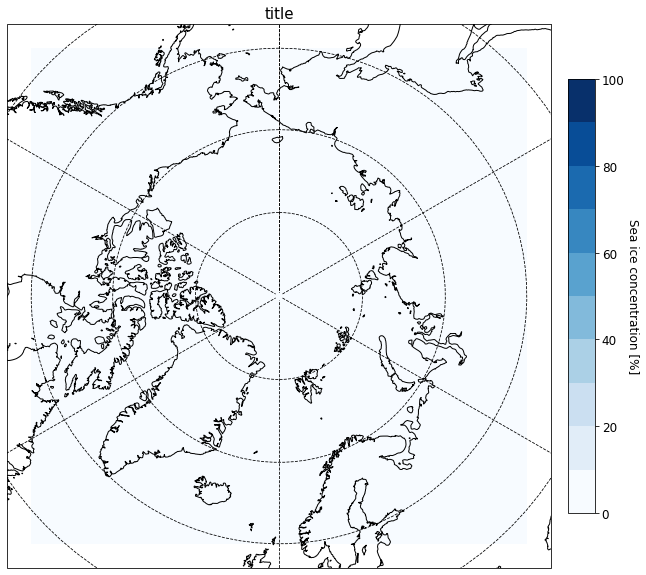

In [182]:
fig = plt.figure(1, figsize=[15,10])
ax = plt.subplot(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90.0))
gridlons = sea_ice_above_60['lon'].values
gridlats = sea_ice_above_60['lat'].values 

cmap = plt.get_cmap('Blues', 10)
ax.gridlines(linestyle='--',color='black')  
mapped_grid_summer = ax.pcolormesh(gridlons, gridlats, data_array_bool, transform=ccrs.PlateCarree(), shading='auto',
                            cmap=cmap, vmin=0, vmax=100)

#ax.set_extent([-45, 45, 60, 90], crs=ccrs.PlateCarree())

ax.coastlines()
#XR_all_years['ice_conc'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.epsg(6931))

cb = plt.colorbar(mapped_grid_summer, orientation="vertical", pad=0.02, 
                  aspect=16, shrink=0.8)
cb.set_label('Sea ice concentration [%]',size=12,rotation=270,labelpad=15)
cb.ax.tick_params(labelsize=12)

ax.set_title('title', size=15)
plt.show()
# fig.savefig(f'fig/{figname}.png')